In [11]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# 📂 Chargement des données
input_path = "../../data/processed/dataset_clean_no_outliers.parquet"
df = pd.read_parquet(input_path)

# Encodage de la classe A-G
le_grade = LabelEncoder()
df['grade_encoded'] = le_grade.fit_transform(df['grade'])

# Création des groupes de risque
def map_grade_group(grade):
    if grade in ['A', 'B']:
        return 0  # Faible
    elif grade in ['C', 'D']:
        return 1  # Moyen
    else:
        return 2  # Élevé

df['grade_group'] = df['grade'].apply(map_grade_group)

# ✅ Sélection des features
df['home_ownership_encoded'] = LabelEncoder().fit_transform(df['home_ownership'])
df['purpose_encoded'] = LabelEncoder().fit_transform(df['purpose'])
df['job_category_encoded'] = LabelEncoder().fit_transform(df['job_category'])

features = [
    'loan_amnt', 'emp_length', 'monthly_income',
    'home_ownership_encoded', 'purpose_encoded', 'job_category_encoded',
    'installment', 'int_rate', 'term', 'dti'
]

X = df[features]
y_group = df['grade_group']
y_grade = df['grade_encoded']

# 🧪 Split train/test
X_train, X_test, y_train_group, y_test_group, y_train_grade, y_test_grade = train_test_split(
    X, y_group, y_grade, test_size=0.3, random_state=42
)

# ⚖️ Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🧠 Modèle pour prédire le groupe
model_group = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])
model_group.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_group.fit(X_train_scaled, y_train_group, epochs=15, batch_size=64, validation_split=0.2)

# 🔁 Fonction de sous-modèle par groupe
def train_submodel(group_label):
    from sklearn.preprocessing import LabelEncoder

    # Filtrage des données du groupe
    X_sub = X_train[y_train_group == group_label]
    y_sub = y_train_grade[y_train_group == group_label]

    # Réencodage local
    local_encoder = LabelEncoder()
    y_sub_encoded = local_encoder.fit_transform(y_sub)

    X_sub_scaled = scaler.transform(X_sub)

    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_sub_scaled.shape[1],)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(len(local_encoder.classes_), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_sub_scaled, y_sub_encoded, epochs=20, batch_size=64, validation_split=0.2)

    # On retourne le modèle ET l’encodeur local pour les prédictions
    return model, local_encoder

# 🏗️ Entraînement des sous-modèles
model_AB, encoder_AB = train_submodel(0)
model_CD, encoder_CD = train_submodel(1)
model_EFG, encoder_EFG = train_submodel(2)


# 🔮 Prédictions
group_preds = np.argmax(model_group.predict(X_test_scaled), axis=1)
final_preds = []

for i in range(len(X_test)):
    x = X_test_scaled[i:i+1]
    group = group_preds[i]

    if group == 0:
        pred_local = np.argmax(model_AB.predict(x), axis=1)[0]
        pred = encoder_AB.inverse_transform([pred_local])[0]
    elif group == 1:
        pred_local = np.argmax(model_CD.predict(x), axis=1)[0]
        pred = encoder_CD.inverse_transform([pred_local])[0]
    else:
        pred_local = np.argmax(model_EFG.predict(x), axis=1)[0]
        pred = encoder_EFG.inverse_transform([pred_local])[0]

    final_preds.append(pred)


Epoch 1/15


c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3205/3205 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4636 - loss: 0.9735 - val_accuracy: 0.4668 - val_loss: 0.9593
Epoch 2/15
3205/3205 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4664 - loss: 0.9594 - val_accuracy: 0.4668 - val_loss: 0.9595
Epoch 3/15
3205/3205 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4662 - loss: 0.9567 - val_accuracy: 0.4668 - val_loss: 0.9593
Epoch 4/15
3205/3205 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4669 - loss: 0.9580 - val_accuracy: 0.4668 - val_loss: 0.9593
Epoch 5/15
3205/3205 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4662 - loss: 0.9563 - val_accuracy: 0.4668 - val_loss: 0.9593
Epoch 6/15
3205/3205 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4667 - loss: 0.9581 - val_accuracy: 0.4668 - val_loss: 0.9594
Epoch 7/15
3205/3205 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4679 - loss: 0.9572 - val_accuracy: 0.4668 - val_loss: 0.9594
Epoch 8/15
3205/3205 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4673 - loss: 0.9564 - val_accurac

c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1495/1495 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6441 - loss: 0.6539 - val_accuracy: 0.6414 - val_loss: 0.6526
Epoch 2/20
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6484 - loss: 0.6487 - val_accuracy: 0.6414 - val_loss: 0.6526
Epoch 3/20
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6458 - loss: 0.6502 - val_accuracy: 0.6414 - val_loss: 0.6528
Epoch 4/20
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6460 - loss: 0.6500 - val_accuracy: 0.6414 - val_loss: 0.6531
Epoch 5/20
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6463 - loss: 0.6499 - val_accuracy: 0.6414 - val_loss: 0.6526
Epoch 6/20
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6449 - loss: 0.6507 - val_accuracy: 0.6414 - val_loss: 0.6526
Epoch 7/20
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6466 - loss: 0.6497 - val_accuracy: 0.6414 - val_loss: 0.6526
Epoch 8/20
1495/1495 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6481 - loss: 0.6488 - val_accurac

c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\Pierre\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 638, in run_forever

  File "C:\Users\Pierre\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1971, in _run_once

  File "C:\Users\Pierre\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 84, in _run

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3044, in run_cell

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3099, in _run_cell

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3303, in run_cell_async

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3486, in run_ast_nodes

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3546, in run_code

  File "C:\Users\Pierre\AppData\Local\Temp\ipykernel_5768\3085302668.py", line 73, in <module>

  File "C:\Users\Pierre\AppData\Local\Temp\ipykernel_5768\3085302668.py", line 68, in train_submodel

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 377, in fit

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 220, in function

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 133, in multi_step_on_iterator

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 114, in one_step_on_data

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 61, in train_step

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\keras\src\trainers\trainer.py", line 383, in _compute_loss

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\keras\src\trainers\trainer.py", line 351, in compute_loss

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\keras\src\trainers\compile_utils.py", line 690, in __call__

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\keras\src\trainers\compile_utils.py", line 699, in call

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\keras\src\losses\loss.py", line 67, in __call__

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\keras\src\losses\losses.py", line 33, in call

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\keras\src\losses\losses.py", line 2330, in sparse_categorical_crossentropy

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\keras\src\ops\nn.py", line 2000, in sparse_categorical_crossentropy

  File "c:\Users\Pierre\Desktop\Projet Crédit pour tous\.venv\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 753, in sparse_categorical_crossentropy

Received a label value of 3 which is outside the valid range of [0, 2).  Label values: 3 2 2 2 3 3 3 2 2 3 3 2 2 2 2 2 2 2 2 3 2 3 2 3 2 3 3 2 3 2 2 3 2 2 3 2 2 2 3 3 2 2 2 2 2 3 3 2 3 2 2 2 3 2 3 2 2 3 2 3 2 2 2 2
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_multi_step_on_iterator_829117]

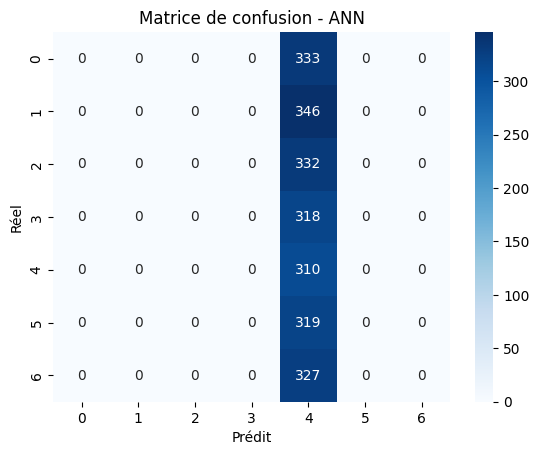

In [ ]:
print("🎯 Rapport de classification :")
print(classification_report(y_test_grade, final_preds, target_names=le_grade.classes_))

cm = confusion_matrix(y_test_grade, final_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le_grade.classes_, yticklabels=le_grade.classes_)
plt.title("Matrice de confusion finale (Grade A→G)")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()